In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import cv2
from google.colab.patches import cv2_imshow
import torch.optim as optim
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import glob
from sklearn.model_selection import train_test_split

BASE_PATH = 'drive/MyDrive/course_project/'

MONTGOMERY_PATH = 'drive/MyDrive/course_project/Montgomery/MontgomerySet/'
CHINA_PATH = 'drive/MyDrive/course_project/ChinaSet_AllFiles/ChinaSet_AllFiles/'

MONTGOMERY_XRAYS_PATH = MONTGOMERY_PATH + 'CXR_png'
CHINA_XRAYS_PATH = CHINA_PATH + 'CXR_png'

MONTGOMERY_INFO_PATH = MONTGOMERY_PATH + 'ClinicalReadings'
CHINA_INFO_PATH = CHINA_PATH + 'ClinicalReadings'

MONTGOMERY_RIGHTMASK_PATH = MONTGOMERY_PATH + 'ManualMask/rightMask'
MONTGOMERY_LEFTMASK_PATH = MONTGOMERY_PATH + 'ManualMask/leftMask'
CHINA_MASKS_PATH = CHINA_PATH + 'mask/'

IMAGES_PATH = 'drive/MyDrive/course_project/images/' # folder to save all prepared images from both datasets
MASKS_PATH = 'drive/MyDrive/course_project/masks/' # masks for both datatsets

TRAIN_UNET_PATH = 'drive/MyDrive/course_project/train_unet'
VAL_UNET_PATH = 'drive/MyDrive/course_project/val_unet'
TEST_UNET_PATH = 'drive/MyDrive/course_project/test_unet'

TRAIN_PATH = 'drive/MyDrive/course_project/train'
VAL_PATH = 'drive/MyDrive/course_project/val'
TEST_PATH = 'drive/MyDrive/course_project/test'

weights_dir = 'drive/MyDrive/course_project/weight'

IMG_SIZE = 512
BN_EPS = 1e-3
MEAN =  np.array([0.485, 0.456, 0.406]) 
STD =  np.array([0.229, 0.224, 0.225])
BATCH_SIZE = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda')

Let's create and teach U-Net model to segment lungs from x-rays images.

In [16]:
!pip install torchviz

### **Dataset**

As both x-rays from different datasets look different (one images more light, one images have lung area which is more dark), let's find min and max values of pixels which belong to lungs and expand it into inerval [0, 255].

In [58]:
def normalize_image(img, mask):
  imin = np.min(img * (mask == 255) + cv2.bitwise_not(mask))
  imax = np.max(img * (mask == 255))
  return (((img - imin) / (imax - imin)) * 255) * (mask == 255)

In [17]:
class LungsDataset(Dataset):
    
    def __init__(self, csv_path, img_dir, mask_dir, aug_transform):
        
        self.description = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.aug_transform = aug_transform
        self.norm_transform = A.Normalize(mean=MEAN, std=STD)
        
    def __getitem__(self, idx):
        
        filename =  self.description.iloc[idx]['filename']  
        img_path = os.path.join(self.img_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.mask_dir is not None:
            
            mask_path = os.path.join(self.mask_dir, filename)
            mask = cv2.imread(mask_path)
            mask = mask[:, :, 0]
            #img = normalize_image(img, mask)
            mask = np.clip(mask, 0, 1).astype("float32")

            augmented = self.aug_transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']CHNCXR_0493_1.png
            img = self.norm_transform(image=img)["image"]

            return torch.FloatTensor(img), torch.FloatTensor(mask)
    
        else:
            augmented = self.aug_transform(image=img)
            img = augmented['image']
            
            img = self.norm_transform(image=img)["image"]
            
            return torch.FloatTensor(img)
        
    def __len__(self):
        return len(self.description)   
        

## **Augmentations**

In [18]:
transforms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.4),
    A.Transpose(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        ])

test_transforms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
        ])

## **Data generators**

In [19]:
# train
train_dataset = LungsDataset(csv_path=BASE_PATH + 'unet_train.csv', img_dir=TRAIN_UNET_PATH, 
                             mask_dir=MASKS_PATH, aug_transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, 
                              shuffle=True)

# validation
val_dataset = LungsDataset(csv_path=BASE_PATH + 'unet_val.csv', img_dir=VAL_UNET_PATH,
                             mask_dir=MASKS_PATH, aug_transform=transforms)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, 
                            shuffle=True)

# test
test_dataset = LungsDataset(csv_path=BASE_PATH + 'unet_test.csv', img_dir=TEST_UNET_PATH, 
                             mask_dir=MASKS_PATH, aug_transform=test_transforms)

test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=4, 
                             shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([3, 512, 512, 3]) torch.Size([3, 512, 512])
0.9843137 474 0.5571774
1.0 490 0.6120637


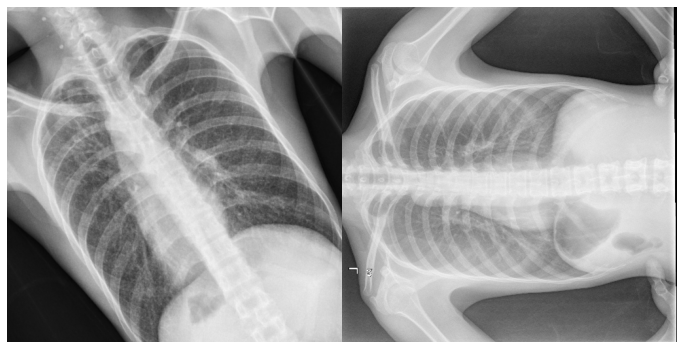

1.0 2 0.32042694
1.0 2 0.21410751


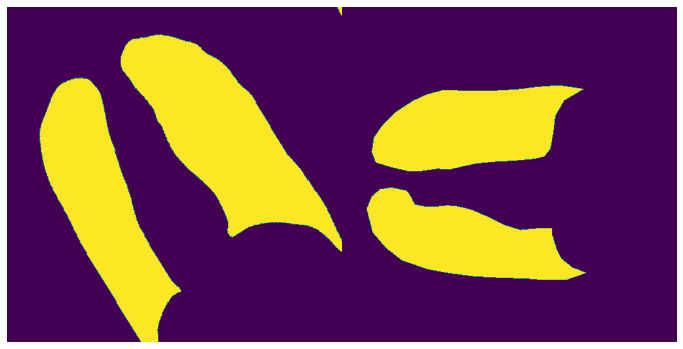

In [7]:
def show_aug(inputs, nrows=1, ncols=2, image=True):
    plt.figure(figsize=(12, 12))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 2:
        inputs = inputs[:2]
        
    for idx in range(len(inputs)):
    
        # normalization
        if image is True:           
            img = inputs[idx].numpy()#.transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            img = np.clip(img, 0,1)
        else:
            img = inputs[idx].numpy().astype(np.float32)
        
        print(img.max(), len(np.unique(img)), img.mean())
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img)
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

## **U-Net**

In [20]:
def crop(x_tensor, pattern):
  _, _, height, weight = pattern.size()
  _, _, x_height, x_weight = x_tensor.size()

  return x_tensor[:, :, 
                (x_height - height) // 2 : height + (x_height - height) // 2 ,
                (x_weight - weight) // 2 : weight + (x_weight - weight) // 2]

                
class UNet(nn.Module):

    def __init__(self, in_channel):
      super(UNet, self).__init__()

      self.max_pooling = nn.MaxPool2d(kernel_size=2)

      self.conv_relu_1 = self.convolution_block(in_channels=in_channel, out_channels=64) # 1
      self.conv_relu_2 = self.convolution_block(in_channels=64, out_channels=128) # 2
      self.conv_relu_3 = self.convolution_block(in_channels=128, out_channels=256) # 3
      self.conv_relu_4 = self.convolution_block(in_channels=256, out_channels=512) # 4
      self.conv_relu_5 = self.convolution_block(in_channels=512, out_channels=1024) # 5

      self.up_conv_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
      self.conv_relu_6 = self.convolution_block(in_channels=1024, out_channels=512, padding=1)
      self.up_conv_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
      self.conv_relu_7 = self.convolution_block(in_channels=512, out_channels=256, padding=1)
      self.up_conv_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
      self.conv_relu_8 = self.convolution_block(in_channels=256, out_channels=128, padding=1)
      self.up_conv_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
      self.conv_relu_9 = self.convolution_block(in_channels=128, out_channels=64, padding=1)

      self.conv_final = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
      self.sigmoid = nn.Sigmoid()
      

    def convolution_block(self, in_channels, out_channels, padding=0):
      return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, eps=BN_EPS),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, eps=BN_EPS),
            nn.ReLU(inplace=True))
      

    def forward(self, x):
      out_1 = self.conv_relu_1(x)
      out_2 = self.conv_relu_2(self.max_pooling(out_1))
      out_3 = self.conv_relu_3(self.max_pooling(out_2))
      out_4 = self.conv_relu_4(self.max_pooling(out_3))
      out_5 = self.conv_relu_5(self.max_pooling(out_4))

      out_6 = self.up_conv_1(out_5)
      out_6 = self.conv_relu_6(torch.cat((crop(out_4, out_6), out_6), dim=1))
      out_7 = self.up_conv_2(out_6)
      out_7 = self.conv_relu_7(torch.cat((crop(out_3, out_7), out_7) ,dim=1))
      out_8 = self.up_conv_3(out_7)
      out_8 = self.conv_relu_8(torch.cat((crop(out_2, out_8), out_8), dim=1))
      out_9 = self.up_conv_4(out_8)
      out_9 = self.conv_relu_9(torch.cat((crop(out_1, out_9), out_9), dim=1))

      out = self.conv_final(out_9)
      out = self.sigmoid(out)
      return out



In [26]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_classes=1):
        super().__init__()
        
        self.base_model = torchvision.models.resnet50(pretrained=False)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])        
        self.layer1_1x1 = convrelu(256, 256, 1, 0)       
        self.layer2 = self.base_layers[5]         
        self.layer2_1x1 = convrelu(512, 512, 1, 0)  
        self.layer3 = self.base_layers[6]         
        self.layer3_1x1 = convrelu(1024, 1024, 1, 0)  
        self.layer4 = self.base_layers[7] 
        self.layer4_1x1 = convrelu(2048, 2048, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(1024 + 2048, 1024, 3, 1)
        self.conv_up2 = convrelu(512 + 1024, 512, 3, 1)
        self.conv_up1 = convrelu(256 + 512, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 64, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2) 
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)
        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)
        
        out = torch.sigmoid(self.conv_last(x))  

        return out

In [27]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class PreResNetUNet(nn.Module):

    def __init__(self, n_classes=1):
        super().__init__()
        
        self.base_model = torchvision.models.resnet50(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])        
        self.layer1_1x1 = convrelu(256, 256, 1, 0)       
        self.layer2 = self.base_layers[5]         
        self.layer2_1x1 = convrelu(512, 512, 1, 0)  
        self.layer3 = self.base_layers[6]         
        self.layer3_1x1 = convrelu(1024, 1024, 1, 0)  
        self.layer4 = self.base_layers[7] 
        self.layer4_1x1 = convrelu(2048, 2048, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(1024 + 2048, 1024, 3, 1)
        self.conv_up2 = convrelu(512 + 1024, 512, 3, 1)
        self.conv_up1 = convrelu(256 + 512, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 64, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2) 
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)
        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)
        
        out = torch.sigmoid(self.conv_last(x))  

        return out

## **Metrics and loss**

In [21]:
## Metric

def jaccard_coef_metric(inputs, target, eps=1e-7):
    intersection = (target * inputs).sum()
    union = (target.sum() + inputs.sum()) - intersection + eps

    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection + eps) / union

def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

## Loss

def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

## **Train**

In [10]:
def train_one_epoch(model, optimizer, lr_scheduler, metric,
                    dataloader, epoch, criterion=bce_dice_loss):
    
    print("Start Train ...")
    model.train()

    losses = []
    accur = []

    for data, target in dataloader:

        data = data.permute(0,3,1,2).to(DEVICE)
        targets = target.unsqueeze(1).to(DEVICE)

        outputs = model(data)

        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        train_dice = metric(out_cut, targets.data.cpu().numpy())

        loss = criterion(outputs, targets)

        losses.append(loss.item())
        accur.append(train_dice)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if lr_scheduler is not None:
        lr_scheduler.step()

    lr = lr_scheduler.get_last_lr()[0]
    print("Epoch [%d]" % (epoch),
          "Mean loss on train:", np.array(losses).mean(), 
          "Mean DICE on train:", np.array(accur).mean(), 
          "Learning Rate:", lr)

    
    return np.array(losses).mean(), np.array(accur).mean(), lr


def val_epoch(model, metric, dataloader, epoch, threshold=0.5):
    
    print("Start Validation ...")
    model.eval()
    
    val_acc = []

    with torch.no_grad():
        for data, targets in dataloader:

            data = data.permute(0,3,1,2).to(DEVICE)
            targets = targets.unsqueeze(1).to(DEVICE)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            val_dice = metric(out_cut, targets.data.cpu().numpy())
            val_acc.append(val_dice)

        print("Epoch:  " + str(epoch) + "  Threshold:  " + str(threshold)\
              + " Mean Validation DICE Score:", np.array(val_acc).mean())
        
        return  np.array(val_acc).mean()

In [11]:
# model = ResNetUNet().to(DEVICE)
# model = UNet(3).to(DEVICE)
model = PreResNetUNet().to(DEVICE)

In [82]:
for param in model.parameters():
    param.requires_grad = True
    
params = [p for p in model.parameters() if p.requires_grad]

num_epochs = 50
optimizer = optimizer = optim.RMSprop(params, lr=0.0002)
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=2e-4)


loss_history = []
train_dice_history = []
val_dice_history = []
lr_history = []

for epoch in range(num_epochs):
        
        
        loss, train_dice, lr = train_one_epoch(model, optimizer, lr_scheduler, 
                                               dice_coef_metric, train_dataloader, epoch)
    
        val_dice = val_epoch(model, dice_coef_metric, val_dataloader, epoch)
        
        
        # train history
        loss_history.append(loss)
        train_dice_history.append(train_dice)
        lr_history.append(lr)
        val_dice_history.append(val_dice)

        # save best weights
        best_dice = max(val_dice_history)
        if val_dice >= best_dice:
            torch.save({'last_state_dict': model.state_dict()},
                        os.path.join(weights_dir, f"{val_dice:0.6f}_.pth"))
            

Start Train ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0] Mean loss on train: 0.6644966681586936 Mean DICE on train: 0.6680067625933183 Learning Rate: 1.0095000000000033e-05
Start Validation ...
Epoch:  0  Threshold:  0.5 Mean Validation DICE Score: 0.8410068233367177
Start Train ...
Epoch [1] Mean loss on train: 0.17973053439500483 Mean DICE on train: 0.9328808249321647 Learning Rate: 1.018999999999998e-05
Start Validation ...
Epoch:  1  Threshold:  0.5 Mean Validation DICE Score: 0.9423706580210838
Start Train ...
Epoch [2] Mean loss on train: 0.15915809349810822 Mean DICE on train: 0.940846230120046 Learning Rate: 1.028500000000001e-05
Start Validation ...
Epoch:  2  Threshold:  0.5 Mean Validation DICE Score: 0.9468864058885418
Start Train ...
Epoch [3] Mean loss on train: 0.1519354112604831 Mean DICE on train: 0.9435408449286429 Learning Rate: 1.0379999999999958e-05
Start Validation ...
Epoch:  3  Threshold:  0.5 Mean Validation DICE Score: 0.9462515092229968
Start Train ...
Epoch [4] Mean loss on train: 0.12993312959975384 Mea

In [83]:
# Load the best weights
best_weights =  sorted(glob.glob(weights_dir + "/*"),
                    key= lambda x: x[8:-5])[-1]
checkpoint = torch.load(best_weights)
model.load_state_dict(checkpoint['last_state_dict'])

print(f'Loaded model: {best_weights.split("/")[-1]}')

Loaded model: 0.963951_.pth


In [84]:
df_logs = pd.DataFrame(
    {'loss': loss_history,
     'train_dice':train_dice_history,
     'val_dice': val_dice_history
    })

df_logs.to_csv(BASE_PATH + "preres_unet_logs.csv", index=False)

No handles with labels found to put in legend.


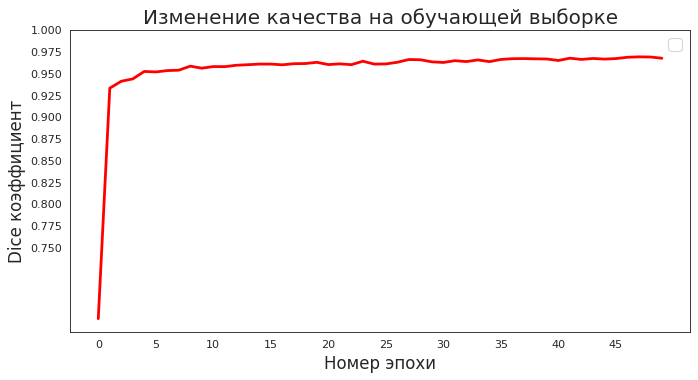

In [85]:
# train dice
sns.set_style("white")
fig = plt.figure(figsize=(10, 5), dpi=80)
plt.plot(np.arange(50), train_dice_history, color="red", linewidth=2.5, linestyle="-")

plt.xticks(np.arange(0, 50, 5))
plt.yticks(np.linspace(0.75, 1, 11))

plt.ylabel("Dice коэффициент", fontsize=15)
plt.xlabel("Номер эпохи", fontsize=15)
plt.title("Изменение качества на обучающей выборке", fontsize=18)
plt.legend(fontsize=15);

plt.show()

fig.savefig(BASE_PATH + 'preres_unet_train_dice.png')

No handles with labels found to put in legend.


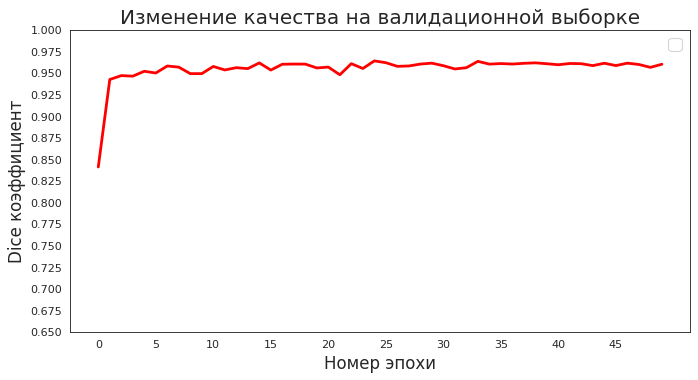

In [86]:

# val dice
sns.set_style("white")
fig = plt.figure(figsize=(10, 5), dpi=80)
plt.plot(np.arange(50), val_dice_history, color="red", linewidth=2.5, linestyle="-")

plt.xticks(np.arange(0, 50, 5))
plt.yticks(np.linspace(0.65, 1, 15))

plt.ylabel("Dice коэффициент", fontsize=15)
plt.xlabel("Номер эпохи", fontsize=15)
plt.title("Изменение качества на валидационной выборке", fontsize=18)
plt.legend(fontsize=15);

plt.show()

fig.savefig(BASE_PATH + 'preres_unet_val_dice.png')

No handles with labels found to put in legend.


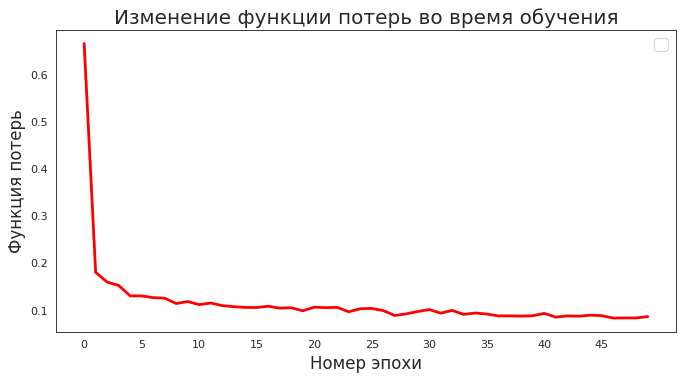

In [87]:
# train dice
sns.set_style("white")
fig = plt.figure(figsize=(10, 5), dpi=80)
plt.plot(np.arange(50), loss_history, color="red", linewidth=2.5, linestyle="-")

plt.xticks(np.arange(0, 50, 5))
#plt.yticks(np.linspace(0.75, 1, 11))

plt.ylabel("Функция потерь", fontsize=15)
plt.xlabel("Номер эпохи", fontsize=15)
plt.title("Изменение функции потерь во время обучения", fontsize=18)
plt.legend(fontsize=15);

plt.show()

fig.savefig(BASE_PATH + 'preres_unet_loss.png')

## **Оценка качества модели на тестовой выборки**

In [30]:
# Load the best weights
model = PreResNetUNet().to(DEVICE)

best_weights =  sorted(glob.glob("drive/MyDrive/course_project/weight_res_unet" + "/*"),
                    key= lambda x: x[8:-5])[-1]
checkpoint = torch.load(best_weights)
model.load_state_dict(checkpoint['last_state_dict'])

print(f'Loaded model: {best_weights.split("/")[-1]}')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Loaded model: 0.957976_.pth


In [31]:
model.eval()
threshold = 0.5

test_acc = []

with torch.no_grad():
    for data_batch, targets in test_dataloader:

        data_batch = data_batch.permute(0,3,1,2).to(DEVICE)
        targets = targets.unsqueeze(1).to(DEVICE)

        outputs = model(data_batch)

        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < threshold)] = 0.0
        out_cut[np.nonzero(out_cut >= threshold)] = 1.0
        
        test_dice = dice_coef_metric(out_cut, targets.data.cpu().numpy())
        test_acc.append(test_dice)

print(np.array(test_acc).mean())
print(test_acc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.9674306143544833
[0.9634147445823938, 0.9609199319985202, 0.9668337900417385, 0.9603067679495347, 0.9713371045656389, 0.9713356936762131, 0.9778662676673443]
